# A bit about linear model and regularizers
This is the companion notebook for the Medium post.

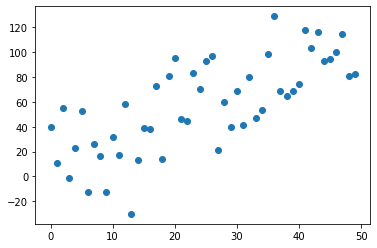

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# In this example, we are going to include a dataset with only 2 dimensions
# These are the parameters for the noise
mean = 3
stddev = 25
size = 50

# These are the parameters of the true model
beta0 = 3
beta1 = 2

# Generating noise for the samples
noise = np.random.normal(mean, stddev, size)

# Generating the data using a line plus noise
x = np.arange(size)
y = beta0 + beta1*x + noise

# Plotting the data
plt.scatter(x,y)

## Plotting the theoretical linear model

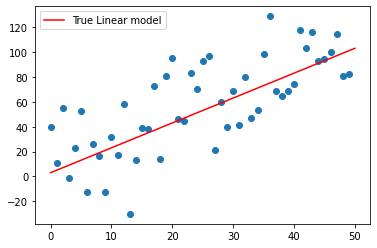

In [74]:
# Plotting the "true" linear model
x0 = 0
x1 = 50
y0 = beta0 + beta1*x0
y1 = beta0 + beta1*x1

# Plotting the data
plt.scatter(x,y)
plt.plot([x0,x1], [y0,y1], color="red", label="True Linear model")
plt.legend()

## Mean Squared Error

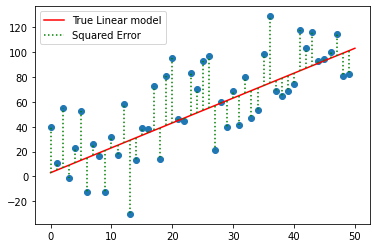

In [75]:
true_model = lambda x: beta0 + beta1*x

# Plotting the data
plt.scatter(x,y)

# Plotting the true linear model
plt.plot([x0,x1], [y0,y1], color="red", label="True Linear model")

# Plotting the mean squared error
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]], 
        [true_model(x[i]), y[i]], 
        color='green', 
        linestyle='dotted', 
        label="Squared Error" if i == len(x)-1 else None)
plt.legend()

## Estimation of the linear model

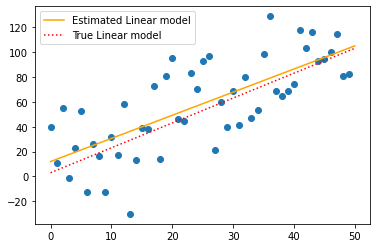

In [76]:
# Function to fit linear model to data
def fit_estimator(x, y, include_bias=True):
    if include_bias:
        x = np.column_stack((np.ones((len(x), 1)), x))
    return np.linalg.inv(x.T@x)@x.T@y

# Fitting the linear model
betas = fit_estimator(x,y)
beta0hat = betas[0]
beta1hat = betas[1]

est_model = lambda x: beta0hat + beta1hat*x

# Plotting the data
plt.scatter(x,y)

# Plotting the true linear model
plt.plot([x0,x1], [est_model(x0),est_model(x1)], color="orange", label="Estimated Linear model")
plt.plot([x0,x1], [y0,y1], color="red", label="True Linear model", linestyle='dotted')

plt.legend()

## Ridge

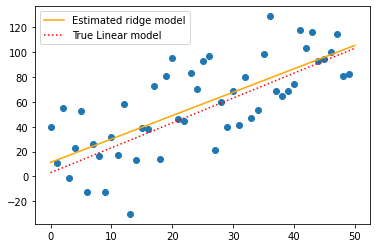

In [77]:
# Function to fit a ridge model to data
def fit_ridge_regressor(x, y, reg_lambda, include_bias=True):
    if include_bias:
        x = np.column_stack((np.ones((len(x), 1)), x))
    return np.linalg.inv(x.T@x + reg_lambda*np.eye(x.shape[1]))@x.T@y

# Fitting the linear model
betas = fit_ridge_regressor(x, y, 0.8)
beta0hat = betas[0]
beta1hat = betas[1]

est_model = lambda x: beta0hat + beta1hat*x

# Plotting the data
plt.scatter(x,y)

# Plotting the true linear model
plt.plot([x0,x1], [est_model(x0),est_model(x1)], color="orange", label="Estimated ridge model")
plt.plot([x0,x1], [y0,y1], color="red", label="True Linear model", linestyle='dotted')

plt.legend()

## Seeing how the weigts behave with Ridge

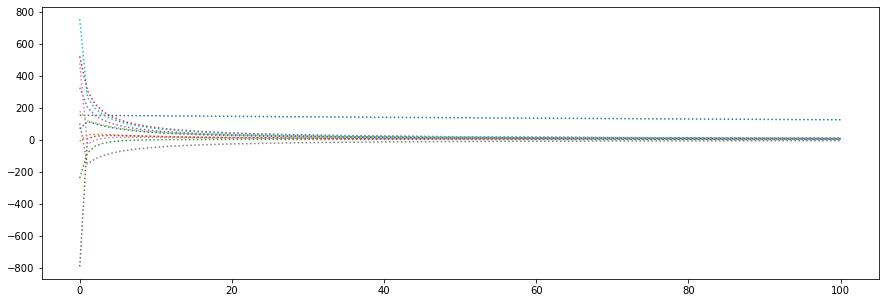

In [78]:
from sklearn.datasets import load_diabetes

# Load the housing dataset
dataset = load_diabetes()

# Split the dataset into x and y
X = dataset.data
y = dataset.target

# Calculate betas for varying regularization lambdas
num_lambdas = 100
reg_results = np.empty((X.shape[1]+1,num_lambdas))
reg_lambdas = np.linspace(start=0, stop=100, num=num_lambdas)
for i, reg_lambda in enumerate(reg_lambdas):
    betas = fit_ridge_regressor(X, y, reg_lambda)
    reg_results[:, i] = betas

# Plot the weights and notice them being pushed towards zero
plt.figure(figsize=(15,5))
for i in range(reg_results.shape[0]):
    plt.plot(reg_lambdas, reg_results[i], linestyle='dotted')


# Lasso

In [79]:
# Load the housing dataset
dataset = load_diabetes()

# Split the dataset into x and y
X = dataset.data
y = dataset.target

# Bias term
X = np.column_stack((np.ones((len(X), 1)), X))
print(X.shape, y.shape)


(442, 11) (442,)


In [80]:
def soft_threshold(z_i,lambda_reg):
    if z_i < - lambda_reg:
        return (z_i + lambda_reg)
    elif z_i >  lambda_reg:
        return (z_i - lambda_reg)
    else: 
        return 0
    

def fit_lasso_regressor(x, y, reg_lambda, include_bias=True, n_iter=50):
    # Random initialization
    betas = np.random.uniform(size=x.shape[1])
    
    # Coordinate descent for n_iter iterations
    for i in range(n_iter):
        # Minimizing one coordinate at a time
        for j in range(X.shape[1]):
            x_j = X[:,j].reshape(-1,1)
            x_minus_j = np.delete(X,j,1)
            betas_minus_j = np.delete(betas, j)
            z_j = float((x_j.T @ (y - x_minus_j@betas_minus_j)) / ( x_j.T@x_j))

            if include_bias and j == 0:
                betas[j] = z_j
            else:
                betas[j] = soft_threshold(z_j, reg_lambda) 
    return betas

In [81]:
fit_lasso_regressor(X, y, 0.5)

array([ 152.13348416,   -8.08723411, -237.0658344 ,  523.46305456,
        321.90805402, -426.50403493,  189.46034916,  -61.10257251,
        130.59500582,  616.21027071,   67.68041124])

## Seeing how the weigts behave with Lasso

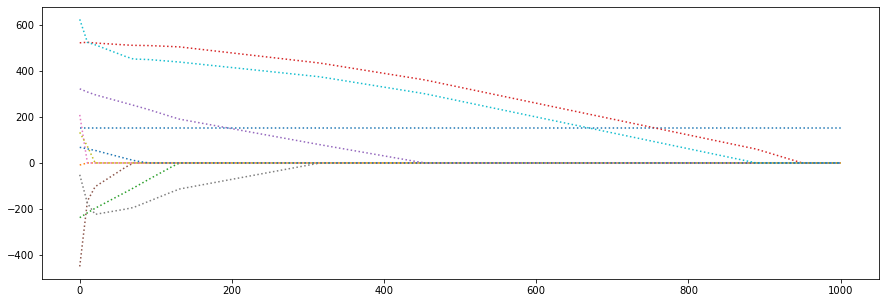

In [82]:
# Calculate betas for varying regularization lambdas
num_lambdas = 100
reg_results = np.empty((X.shape[1],num_lambdas))
reg_lambdas = np.linspace(start=0, stop=1000, num=num_lambdas)
for i, reg_lambda in enumerate(reg_lambdas):
    betas = fit_lasso_regressor(X, y, reg_lambda)
    reg_results[:, i] = betas

# Plot the weights and notice them being pushed towards zero
plt.figure(figsize=(15,5))
for i in range(reg_results.shape[0]):
    plt.plot(reg_lambdas, reg_results[i], linestyle='dotted')

## Elastic-Net

In [83]:

def fit_elastic_net_regressor(x, y, reg_lambda, reg_ratio, include_bias=True, n_iter=50):
    # Random initialization
    betas = np.random.uniform(size=x.shape[1])
    
    # Coordinate descent for n_iter iterations
    for i in range(n_iter):
        # Minimizing one coordinate at a time
        for j in range(X.shape[1]):
            x_j = X[:,j].reshape(-1,1)
            x_minus_j = np.delete(X,j,1)
            betas_minus_j = np.delete(betas, j)
            z_j = float((x_j.T @ (y - x_minus_j@betas_minus_j))/ ( x_j.T@x_j + (1+reg_lambda*(1-reg_ratio))))

            if include_bias and j == 0:
                betas[j] = z_j
            else:
                betas[j] = soft_threshold(z_j, reg_lambda*reg_ratio) 
    return betas

In [84]:
fit_elastic_net_regressor(X, y, 20, 0.8)

array([150.43176734,  15.35689176,   0.        , 115.98384109,
        78.64239999,  14.63934571,   3.25269436, -63.4244285 ,
        63.90607963, 105.54996659,  57.33721952])

## Seeing how the weigts behave with Elastic-Net

In [85]:
# Calculate betas for varying regularization lambdas
def try_elastic_net(fixed_ratio, X, y):
    num_lambdas = 100
    reg_results = np.empty((X.shape[1],num_lambdas))
    reg_lambdas = np.linspace(start=0, stop=100, num=num_lambdas)
    for i, reg_lambda in enumerate(reg_lambdas):
        betas = fit_elastic_net_regressor(X, y, reg_lambda, fixed_ratio)
        reg_results[:, i] = betas

    # Plot the weights and notice them being pushed towards zero
    plt.figure(figsize=(15,5))
    for i in range(reg_results.shape[0]):
        plt.plot(reg_lambdas, reg_results[i], linestyle='dotted')

Smilar to Ridge when the rate is closer to 0.

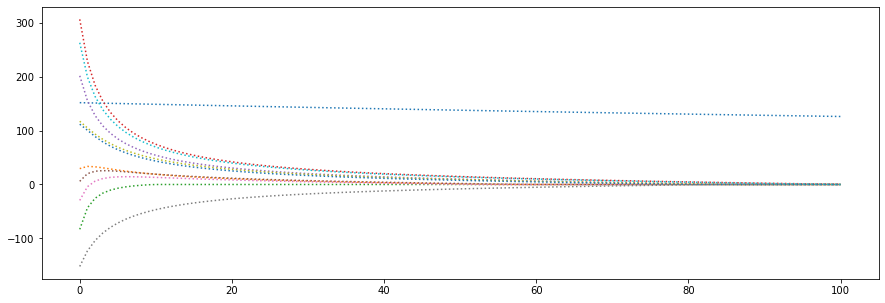

In [86]:
try_elastic_net(0.1, X, y)

Smilar to Ridge when the rate is closer to 1.

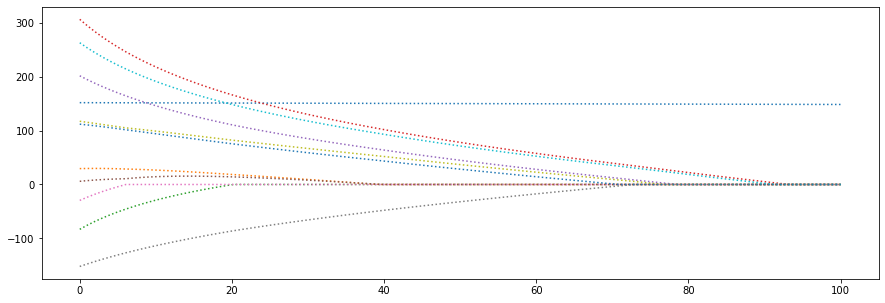

In [87]:
try_elastic_net(0.9, X, y)

## Exercise with Scikit-Learn

In [88]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data separately for training and testing sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [89]:
def perform_regression(method, params, X_train, y_train, X_test, y_test):
    """
    Performs hyperparameter optimization, searching for the
    best regularization parameters, then makes predictions and
    computes regression error on the test set.
    """
    # Optimization
    grid = GridSearchCV(method, params, cv=5)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    # Prediction
    predictions = best_model.predict(X_test)
    # Test error
    mse = mean_squared_error(y_test, predictions)
    return best_params, mse

In [90]:
# Parameters for each method
ridge_params = {'alpha': np.logspace(-4, 4, 100)}
lasso_params = {'alpha': np.logspace(-4, 4, 100)}
elastic_params = {'alpha': np.logspace(-4, 4, 100), 'l1_ratio': np.linspace(0.1, 0.9, 10)}

In [91]:

# Perform regression for each method
results = []
methods = [
    (Ridge(), ridge_params),
    (Lasso(), lasso_params),
    (ElasticNet(), elastic_params)
]

for method, params in methods:
    best_params, mse = perform_regression(method, params, X_train_scaled, y_train, X_test_scaled, y_test)
    results.append({
        'Method': method.__class__.__name__,
        'Best Alpha': best_params.get('alpha', 'N/A'),
        'Best L1 Ratio': best_params.get('l1_ratio', 'N/A'),
        'MSE': mse
    })

# Display the results
results_df = pd.DataFrame(results)
print(results_df)

       Method  Best Alpha Best L1 Ratio          MSE
0       Ridge   37.649358           N/A  2859.091303
1       Lasso    1.917910           N/A  2799.109196
2  ElasticNet    0.170735      0.188889  2854.562885


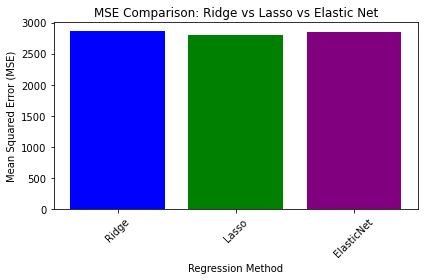

In [92]:
# Bar chart for MSE comparison
plt.figure(figsize=(6, 4))
plt.bar(results_df['Method'], results_df['MSE'], color=['blue', 'green', 'purple'])
plt.xlabel('Regression Method')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Comparison: Ridge vs Lasso vs Elastic Net')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()